# Size-based NPZ model

Our third model application is a size-structured plankton community model in an idealized physical setting, similar to a chemostat. The presented model is an adaptation of the ASTroCAT model, developed by Neil Banas.
> Banas, N. S. (2011). Adding complex trophic interactions to a size-spectral plankton model: Emergent diversity patterns and limits on predictability. Ecological Modelling, 222(15), 2663-2675.

ASTroCAT was developed as a tool to investigate the complex trophic interactions between phytoplankton and zooplankton in a systematic simplified setting, resolving a diverse plankton community via a size spectrum. Cell or organism size is used in this model as a “master trait”, defining the parameters of specific plankton types via allometric functions, taken from literature (Litchman et al. 2008). This allows for a functional and quantifiable model to investigate mechanisms affecting and sustaining phytoplankton diversity.

Banas considered model dynamics under variable forcing or with stochastic grazing parameters. Here, we focus on the basic parameter setup under constant forcing. The model features an allometric description of multiple size-classes for phytoplankton growing on a single nutrient and zooplankton grazing on phytoplankton. While trophic interactions between size classes are highly resolved, other ecological processes are neglected (e.g., there are no detrital or regeneration pathways).  

This model lends itself well to highlight the flexibility of the XSO framework. A state variable defined within a _component_ can be defined with dimensions, so that it can represent an array of state variables of flexible size, as long as dimension labels match across interacting _components_. The size of the state variable array depends on the number of values supplied at model setup. The built-in vectorization allows the model to compute correctly and efficiently, even with large numbers of state variables. We showcase this feature by running the model with 2 to 50 size classes and comparing bulk phytoplankton biomass between runs. The only modification necessary is varying the number of values supplied at model setup.

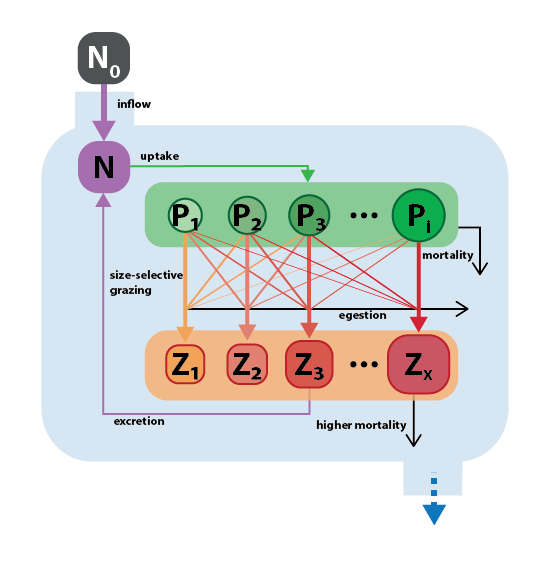

In [1]:
from IPython.display import Image
Image(filename=('images/03_schematics_NPZSizeBased.png'), width=600)

# Allometric functions

In [2]:
import numpy as np

def calculate_sizes(size_min, size_max, num):
    """initializes log spaced array of sizes from ESD size range"""
    numbers = np.array([i for i in range(num)])
    sizes = (np.log(size_max) - np.log(size_min))* numbers / (num-1) + np.log(size_min)
    return np.exp(sizes)

def calculate_zoo_I0(sizes):
    """initializes allometric parameters based on array of sizes (ESD)"""
    return 26 * sizes ** -0.4

def calculate_phyto_mu0(sizes):
    """initializes allometric parameters based on array of sizes (ESD)
    allometric relationships are taken from meta-analyses of lab data"""
    return 2.6 * sizes ** -0.45

def calculate_phyto_ks(sizes):
    """Test"""
    return sizes * .1

def calculate_opt_size(sizes):
    """Calculating optimal prey size from zooplankton sizes"""
    return 0.65 * sizes ** 0.56


def init_phiP(phytosize, zoopreyoptsize):
    """creates array of feeding preferences [P...P10] for each [Z]"""
    phiP = np.array([[np.exp(-((np.log10(xpreyi) - np.log10(xpreyoptj)) / 0.25) ** 2)
                      for xpreyi in phytosize] for xpreyoptj in zoopreyoptsize])
    return phiP

## Set up model parameters

In [3]:
# number size classes of phytoplankton and zooplankotn
PZ_num = 40

# create initial biomass
phyto_init = np.tile(.5/PZ_num, (PZ_num))
zoo_init = np.tile(.1/PZ_num, (PZ_num))

# calculate log-spaced size classes from ranges and total number
phyto_sizes = calculate_sizes(1.,20.,PZ_num)
zoo_sizes = 2.16 * phyto_sizes **1.79  # calculate_sizes(2.16,280.,PZ_num)

# ingestion
zoo_I0 = calculate_zoo_I0(zoo_sizes)

# growth
phyto_mu0 = calculate_phyto_mu0(phyto_sizes)
phyto_ks = calculate_phyto_ks(phyto_sizes)

# grazing
preyoptsize = calculate_opt_size(zoo_sizes)
phiP = init_phiP(phyto_sizes, preyoptsize)

In [4]:
2.16 * phyto_sizes **1.79

array([  2.16      ,   2.47837884,   2.84368595,   3.26283847,
         3.74377306,   4.29559626,   4.92875688,   5.65524386,
         6.48881329,   7.44524886,   8.54266074,   9.80182852,
        11.24659461,  12.90431577,  14.80638108,  16.98880625,
        19.49291569,  22.36612487,  25.66283821,  29.44547923,
        33.78567248,  38.76559985,  44.47955661,  51.03573693,
        58.55828257,  67.18963345,  77.09322482,  88.45658189,
       101.49487062, 116.45497195, 133.62015646, 153.31544814,
       175.91377873, 201.84304924, 231.59423224, 265.7306685 ,
       304.89873387, 349.84007846, 401.40566982, 460.57190609])

In [5]:
preyoptsize

array([ 1.0004778 ,  1.08055596,  1.16704357,  1.26045364,  1.36134025,
        1.47030181,  1.58798464,  1.7150868 ,  1.85236221,  2.00062513,
        2.160755  ,  2.33370165,  2.52049093,  2.72223082,  2.94011795,
        3.17544475,  3.42960708,  3.70411255,  4.00058941,  4.32079625,
        4.66663243,  5.0401493 ,  5.44356243,  5.87926472,  6.34984058,
        6.85808129,  7.40700155,  7.99985734,  8.64016526,  9.33172338,
       10.07863374, 10.88532675, 11.7565874 , 12.69758368, 13.71389723,
       14.81155643, 15.99707218, 17.27747651, 18.6603643 , 20.15393831])

In [6]:
phiP

array([[9.99999311e-01, 9.82568532e-01, 9.31665344e-01, ...,
        2.61240319e-11, 6.87320235e-12, 1.74506655e-12],
       [9.82048862e-01, 9.99998677e-01, 9.82651891e-01, ...,
        9.61150092e-11, 2.62067590e-11, 6.89555710e-12],
       [9.30520845e-01, 9.81964107e-01, 9.99997838e-01, ...,
        3.41194351e-10, 9.64111171e-11, 2.62897428e-11],
       ...,
       [2.28579913e-11, 8.41431613e-11, 2.98905238e-10, ...,
        9.99839251e-01, 9.85522895e-01, 9.37426431e-01],
       [5.97278890e-12, 2.27856334e-11, 8.38839718e-11, ...,
        9.78784076e-01, 9.99831028e-01, 9.85599025e-01],
       [1.50582978e-12, 5.95337172e-12, 2.27134999e-11, ...,
        9.24492139e-01, 9.78692175e-01, 9.99822601e-01]])

## Visualize grazing preferences

Text(0.5, 1.0, 'Grazing Preferences across size classes')

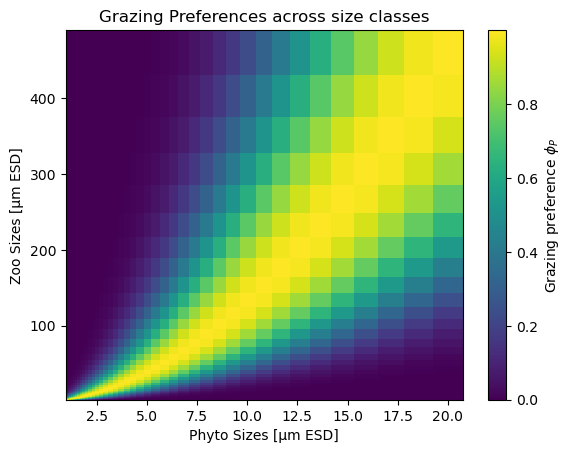

In [7]:
import matplotlib.pyplot as plt
x, y = np.meshgrid(phyto_sizes, zoo_sizes)
plt.pcolormesh(x, y, phiP)
plt.colorbar(label='Grazing preference $\phi_P$')
plt.ylabel("Zoo Sizes [µm ESD]")
plt.xlabel("Phyto Sizes [µm ESD]")
plt.title("Grazing Preferences across size classes")

# Model setup

In [8]:
import xso

In [9]:
import sys
sys.path.append('..')

import phydra

In [10]:
from phydra.models import NPxZxSizeBased

In [11]:
NPxZxSizeBased

<xsimlab.Model (13 processes, 33 inputs)>
Core
    solver_type              [in] solver type to use for model
Time
    time_input               [in] ('time',) sequence of time for wh...
Nutrient
    value_label              [in] label / nutrient concentration
    value_init               [in] initial value / nutrient concentr...
Phytoplankton
    biomass_label            [in] label / phytoplankton biomass
    biomass_init             [in] ('phyto',) initial value / phytop...
    phyto_index              [in] ('phyto',) index / size spectrum ...
Zooplankton
    biomass_label            [in] label / zooplankton biomass
    biomass_init             [in] ('zoo',) initial value / zooplank...
    zoo_index                [in] ('zoo',) index / size spectrum of...
N0
    forcing_label            [in] label / external nutrient
    value                    [in] parameter / constant value
Inflow
    var                      [in] label reference / variable affect...
    forcing                  [i

In [15]:
model_setup = xso.setup(solver='solve_ivp', model=NPxZxSizeBased,
            time=np.arange(0,365*10),
            input_vars={
                    # State variables
                    'Nutrient':{'value_label':'N','value_init':1.},
                    'Phytoplankton':{'biomass_label':'P','biomass_init':phyto_init, 'phyto_index':phyto_sizes},
                    'Zooplankton':{'biomass_label':'Z','biomass_init':zoo_init, 'zoo_index': zoo_sizes},
                
                    # Flows:
                    'Inflow':{'forcing':'N0', 'rate':1., 'var':'N'},
                
                    # Growth
                    'Growth':{'resource':'N', 'consumer':'P', 'halfsat':phyto_ks, 'mu_max':phyto_mu0},

                    # Grazing
                    'Grazing':{'resource':'P', 'consumer':'Z',
                               'Imax':zoo_I0, 'KsZ':3., 'phiP':phiP},
                    'GGE':{'grazed_resource':'P', 'assimilated_consumer':'Z', 'egested_detritus':'N', 
                           'epsilon':1./3., 'f_eg':1./3.},
                
                    # Mortality
                    'PhytoMortality':{'var':'P', 'rate':0.1*phyto_mu0},
                    'ZooMortality':{'var':'Z', 'rate':1.},

                    # Forcings
                    'N0':{'forcing_label':'N0', 'value':1.},
            })

In [16]:
model_setup

<xarray.Dataset>
Dimensions:                       (clock: 2, phyto: 40, zoo: 40, time: 3650)
Coordinates:
  * clock                         (clock) int64 0 1
Dimensions without coordinates: phyto, zoo, time
Data variables: (12/33)
    Nutrient__value_label         <U1 'N'
    Nutrient__value_init          float64 1.0
    Phytoplankton__biomass_label  <U1 'P'
    Phytoplankton__biomass_init   (phyto) float64 0.0125 0.0125 ... 0.0125
    Phytoplankton__phyto_index    (phyto) float64 1.0 1.08 1.166 ... 18.52 20.0
    Zooplankton__biomass_label    <U1 'Z'
    ...                            ...
    ZooMortality__var             <U1 'Z'
    ZooMortality__rate            float64 1.0
    N0__forcing_label             <U2 'N0'
    N0__value                     float64 1.0
    Core__solver_type             <U9 'solve_ivp'
    Time__time_input              (time) int64 0 1 2 3 4 ... 3646 3647 3648 3649
Attributes:
    __xsimlab_output_vars__:  Nutrient__value,Phytoplankton__biomass,Zooplank...

# Run the model

In [17]:
from xsimlab.monitoring import ProgressBar

with ProgressBar():
    with NPxZxSizeBased:
        model_out = model_setup.xsimlab.run()

             0% | initialize 

In [18]:
model_out

<xarray.Dataset>
Dimensions:                          (zoo: 40, time: 3650, phyto: 40, clock: 2)
Coordinates:
  * clock                            (clock) int64 0 1
  * phyto                            (phyto) float64 1.0 1.08 ... 18.52 20.0
  * time                             (time) float64 0.0 1.0 ... 3.649e+03
  * zoo                              (zoo) float64 2.16 2.478 ... 401.4 460.6
Data variables: (12/45)
    Core__solver_type                <U9 'solve_ivp'
    GGE__assimilated_consumer        <U1 'Z'
    GGE__assimilation_value          (zoo, time) float64 0.001354 ... 0.0
    GGE__egested_detritus            <U1 'N'
    GGE__egestion_value              (time) float64 0.02469 0.02469 ... 0.2927
    GGE__epsilon                     float64 0.3333
    ...                               ...
    ZooMortality__rate               float64 1.0
    ZooMortality__var                <U1 'Z'
    Zooplankton__biomass             (zoo, time) float64 0.0025 0.003558 ... 0.0
    Zooplankton__biomass_init        (zoo) float64 0.0025 0.0025 ... 0.0025
    Zooplankton__biomass_label       <U1 'Z'
    Zooplankton__zoo_index           (zoo) float64 2.16 2.478 ... 401.4 460.6

# Visualize model output

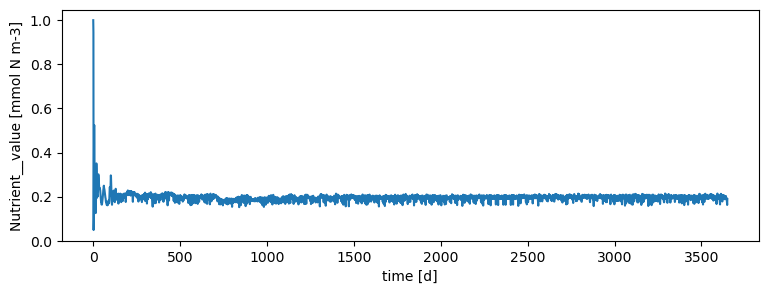

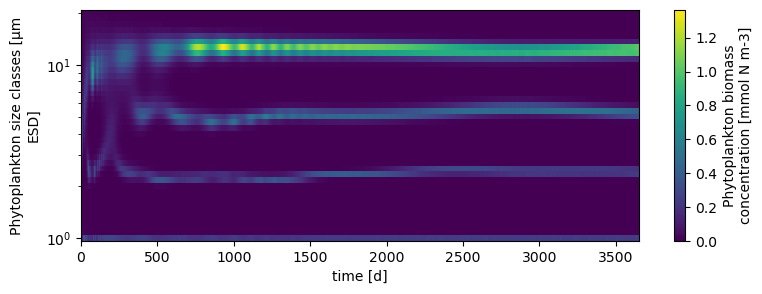

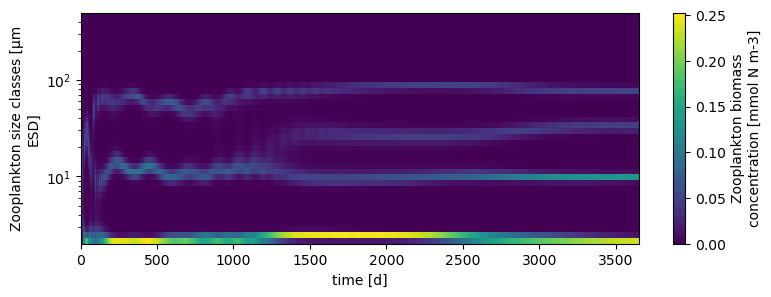

In [19]:
model_out.Nutrient__value.plot(aspect=3, size=3, ylim=0)

model_out.Phytoplankton__biomass.plot(yscale='log', aspect=3, size=3)

model_out.Zooplankton__biomass.plot(yscale='log', aspect=3, size=3)